# Thermocapillary flows: 2D Planar heated channel

In [1]:
from pystencils.session import *
from lbmpy.session import *

from pystencils.boundaries import BoundaryHandling

from lbmpy.phasefield_allen_cahn.analytical import analytical_solution_microchannel
from lbmpy.phasefield_allen_cahn.contact_angle import ContactAngle
from lbmpy.phasefield_allen_cahn.kernel_equations import *
from lbmpy.phasefield_allen_cahn.numerical_solver import get_runge_kutta_update_assignments
from lbmpy.phasefield_allen_cahn.parameter_calculation import calculate_parameters_rti, AllenCahnParameters
from lbmpy.advanced_streaming import LBMPeriodicityHandling
from lbmpy.boundaries import NoSlip, LatticeBoltzmannBoundaryHandling

If `cupy` is installed the simulation automatically runs on GPU

In [2]:
try:
    import cupy
except ImportError:
    cupy = None
    gpu = False
    target = ps.Target.CPU
    print('No cupy installed')

if cupy:
    gpu = True
    target = ps.Target.GPU

## Overview

In this tutorial, we will provide an introduction to thermocapillary flows and solve an example setup using `lbmpy` and `pystencils`. This tutorial builds upon the conservative Allen-Cahn tutorial. Thus it is highly recommended to read mentioned tutorial first.

Thermocapillary flows refer to the motion of fluids induced by temperature gradients at liquid interfaces. They play a crucial role in various natural and industrial processes, such as microfluidics, materials processing, and the behavior of liquid droplets in microgravity environments.

In this tutorial the motion of fluid in a heated microchannel is investigated. This problem has been addressed by numerous authors for example [here](https://doi.org/10.1016/j.ijthermalsci.2010.02.003) to verify thermocapillary flow models. The advantage of this problem is the existance of an analytical solution which is commonly very hard to find in these complex flow problems. Here, we will apply a second order accurate Runge Kutta scheme to solve the heat equation.

## Geometry Setup

First of all the stencils for the phase-field LB step as well as the stencil for the hydrodynamic LB step are defined. According to the stencils the simulation runs either in 2D or 3D

In [3]:
stencil_phase = LBStencil(Stencil.D2Q9)
stencil_hydro = LBStencil(Stencil.D2Q9)

Definition of the parameters used in this tutorial

In [4]:
# domain 
L0 = 256
domain_size = (2 * L0, L0)

# initial timesteps for the temperature solver
timesteps_temperature = 10000
# timesteps for the whole simulation
timesteps = 400000

# Parameters of the simulation
parameters = ThermocapillaryParameters(density_heavy=1.0, density_light=1.0,
                                       dynamic_viscosity_heavy=0.2, dynamic_viscosity_light=0.2,
                                       surface_tension=0.0,
                                       heat_conductivity_heavy=0.2, heat_conductivity_light=0.2,
                                       mobility=0.05, interface_thickness=4,
                                       sigma_ref=0.025, sigma_t=-5e-4)

T_h = 20
T_c = 10
T_0 = 4

Note that the Parametes are defined in the `ThermocapillaryParameters` class. This has the advantage that the class defines for every parameter a symbolic representation. Thus, in the later derivation of the update rules only symbolic parameters occure and the numerical values will come as input parameters via `parameters.symbolic_to_numeric_map`.

In [5]:
parameters

Name,SymPy Symbol,Value
Density heavy phase,$\rho_{H}$,$1.0$
Density light phase,$\rho_{L}$,$1.0$
Relaxation time heavy phase,$\tau_{H}$,$0.6$
Relaxation time light phase,$\tau_{L}$,$0.6$
Relaxation rate Allen Cahn LB,$\omega_{\phi}$,$1.53846153846154$
Gravitational acceleration,$F_{g}$,$0.0$
Interface thickness,$W$,$4$
Mobility,$M_{m}$,$0.05$
Surface tension,$\sigma$,$0.0$
Heat Conductivity Heavy,$\kappa_{H}$,$0.2$


## Fields

As a next step all fields which are needed get defined. To do so we create a `datahandling` object. More details about it can be found in the third tutorial of the [pystencils framework]( http://pycodegen.pages.walberla.net/pystencils/). Basically it holds all fields and manages the kernel runs.

In [6]:
# create a datahandling object
dh = ps.create_data_handling((domain_size), periodicity=(True, False), default_target=target)

# LBM PDF arrays 
g = dh.add_array("g", values_per_cell=len(stencil_hydro))
dh.fill("g", 0.0, ghost_layers=True)
h = dh.add_array("h",values_per_cell=len(stencil_phase))
dh.fill("h", 0.0, ghost_layers=True)

g_tmp = dh.add_array("g_tmp", values_per_cell=len(stencil_hydro))
dh.fill("g_tmp", 0.0, ghost_layers=True)
h_tmp = dh.add_array("h_tmp",values_per_cell=len(stencil_phase))
dh.fill("h_tmp", 0.0, ghost_layers=True)

# velocity, phase-field and temperature array
u = dh.add_array("u", values_per_cell=dh.dim)
dh.fill("u", 0.0, ghost_layers=True)

C = dh.add_array("C")
dh.fill("C", 0.0, ghost_layers=True)
C_tmp = dh.add_array("C_tmp")
dh.fill("C_tmp", 0.0, ghost_layers=True)

temperature = dh.add_array("temperature")
dh.fill("temperature", T_c, ghost_layers=True)

# temporary array for the RK scheme
RK1 = dh.add_array("RK1")
dh.fill("RK1", 0.0, ghost_layers=True)

## Parameter definition

The next step is to calculate all parameters which are needed for the simulation. 

In [7]:
# relaxation rate for the phase-field LBM step
w_c = 1.0/(0.5 + (3.0 * parameters.symbolic_mobility))
# relaxation rate for the hydrodynamic LBM step
omega = parameters.omega(C)

In [8]:
# density for the whole domain
rho_L = parameters.symbolic_density_light
rho_H = parameters.symbolic_density_heavy
density = rho_L + C.center * (rho_H - rho_L)

## Definition of the lattice Boltzmann methods

In [9]:
config_phase = LBMConfig(stencil=stencil_phase, method=Method.CENTRAL_MOMENT,
                         compressible=True, zero_centered=False,
                         relaxation_rate=w_c,
                         force=sp.symbols(f"F_:{stencil_phase.D}"),
                         output={'density': C_tmp}, 
                         velocity_input=u)

method_phase = create_lb_method(config_phase)
method_phase

In [10]:
config_hydro = LBMConfig(stencil=stencil_phase, method=Method.CENTRAL_MOMENT,
                         compressible=False,
                         force=sp.symbols(f"F_:{stencil_hydro.D}"),
                         output={'velocity': u},
                         relaxation_rates=[omega, omega, 1, 1])


method_hydro = create_lb_method(config_hydro)
method_hydro

## Initialization

In [11]:
h_updates = initializer_kernel_phase_field_lb(method_phase, C, u, h, parameters)
g_updates = initializer_kernel_hydro_lb(method_hydro, 1.0, u, g)

h_init = ps.create_kernel(h_updates, target=dh.default_target, cpu_openmp=True).compile()
g_init = ps.create_kernel(g_updates, target=dh.default_target, cpu_openmp=True).compile()

Initialisation of the phase-field, as well as the temperature array

In [12]:
# initialize the domain
def Initialize_distributions():
    Nx = domain_size[0]
    Ny = domain_size[1]
    W = parameters.interface_thickness
    
    for block in dh.iterate(ghost_layers=True, inner_ghost_layers=False):
        x = np.zeros_like(block.midpoint_arrays[0])
        x[:, :] = block.midpoint_arrays[0]
        
        normalised_x = np.zeros_like(x[:, 0])
        normalised_x[:] = x[:, 0] - L0
        omega = np.pi / L0
        # bottom wall
        block["temperature"][:, 0] = T_h + T_0 * np.cos(omega * normalised_x)
        # top wall
        block["temperature"][:, -1] = T_c
                
        y = np.zeros_like(block.midpoint_arrays[1])
        y[:, :] = block.midpoint_arrays[1]
        
        y += Ny // 2
        init_values = 0.5 + 0.5 * np.tanh((y - Ny) / (W / 2))
        block["C"][:, :] = init_values
        block["C_tmp"][:, :] = init_values
        
    if gpu:
        dh.all_to_gpu()            
    
    dh.run_kernel(h_init, **parameters.symbolic_to_numeric_map)
    dh.run_kernel(g_init)

In [13]:
force_h = force_h = interface_tracking_force(C, stencil_phase, parameters)
hydro_force = hydrodynamic_force(C, method_hydro, parameters, body_force=[0, 0, 0],
                                 temperature_field=temperature)

## Definition of the LB update rules

In [14]:
lbm_optimisation = LBMOptimisation(symbolic_field=h, symbolic_temporary_field=h_tmp)
allen_cahn_lb = create_lb_update_rule(lbm_config=config_phase,
                                      lbm_optimisation=lbm_optimisation)

allen_cahn_lb = add_interface_tracking_force(allen_cahn_lb, force_h)

ast_allen_cahn_lb = ps.create_kernel(allen_cahn_lb, target=dh.default_target, cpu_openmp=True)
kernel_allen_cahn_lb = ast_allen_cahn_lb.compile()

In [15]:
force_Assignments = hydrodynamic_force_assignments(u, C, method_hydro, parameters,
                                                   body_force=[0, 0, 0], temperature_field=temperature)

lbm_optimisation = LBMOptimisation(symbolic_field=g, symbolic_temporary_field=g_tmp)
hydro_lb_update_rule = create_lb_update_rule(lbm_config=config_hydro,
                                             lbm_optimisation=lbm_optimisation)
hydro_lb_update_rule = add_hydrodynamic_force(hydro_lb_update_rule, force_Assignments, C, g,
                                              parameters, config_hydro) 

ast_hydro_lb = ps.create_kernel(hydro_lb_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_hydro_lb = ast_hydro_lb.compile()

## Setup of the RK scheme to solve the temperature

In [16]:
a = get_runge_kutta_update_assignments(stencil_hydro, C, temperature, u, [RK1, ],
                                       parameters.heat_conductivity_heavy,
                                       parameters.heat_conductivity_light,
                                       1.0, 1.0, density)

In [17]:
init_RK = [ps.Assignment(RK1.center, temperature.center)]
init_RK_kernel = ps.create_kernel(init_RK, target=dh.default_target, cpu_openmp=True).compile()

In [18]:
TempUpdate1_kernel = ps.create_kernel(a[0], target=dh.default_target, cpu_openmp=True).compile()
TempUpdate2_kernel = ps.create_kernel(a[1], target=dh.default_target, cpu_openmp=True).compile()

## Boundary Conditions

In [19]:
# periodic Boundarys for g, h and C
periodic_BC_C = dh.synchronization_function(C.name, target=dh.default_target, optimization = {"openmp": True})
periodic_BC_T = dh.synchronization_function(temperature.name, target=dh.default_target, optimization = {"openmp": True})


periodic_BC_g = LBMPeriodicityHandling(stencil=stencil_hydro, data_handling=dh, pdf_field_name=g.name,
                                       streaming_pattern='pull')
periodic_BC_h = LBMPeriodicityHandling(stencil=stencil_phase, data_handling=dh, pdf_field_name=h.name,
                                       streaming_pattern='pull')

# No slip boundary for the phasefield lbm
bh_allen_cahn = LatticeBoltzmannBoundaryHandling(method_phase, dh, 'h',
                                                 target=dh.default_target, name='boundary_handling_h',
                                                 streaming_pattern='pull')

# No slip boundary for the velocityfield lbm
bh_hydro = LatticeBoltzmannBoundaryHandling(method_hydro, dh, g.name,
                                            target=dh.default_target, name='boundary_handling_g',
                                            streaming_pattern='pull')

wall = NoSlip()
bh_allen_cahn.set_boundary(wall, make_slice[:, 0])
bh_allen_cahn.set_boundary(wall, make_slice[:, -1])

bh_hydro.set_boundary(wall, make_slice[:, 0])
bh_hydro.set_boundary(wall, make_slice[:, -1])


bh_allen_cahn.prepare()
bh_hydro.prepare()

## Full timestep

In [20]:
def temp_update():
    dh.run_kernel(init_RK_kernel, **parameters.symbolic_to_numeric_map)
    dh.run_kernel(TempUpdate1_kernel, **parameters.symbolic_to_numeric_map)
    dh.run_kernel(TempUpdate2_kernel, **parameters.symbolic_to_numeric_map)
    periodic_BC_T()

In [21]:
# definition of the timestep for the immiscible fluids model
def timeloop():
    # Solve the interface tracking LB step with boundary conditions
    periodic_BC_h()
    bh_allen_cahn()    
    dh.run_kernel(kernel_allen_cahn_lb, **parameters.symbolic_to_numeric_map)
    # Solve the hydro LB step with boundary conditions
    periodic_BC_g()
    bh_hydro()
    dh.run_kernel(kernel_hydro_lb, **parameters.symbolic_to_numeric_map)
    
    dh.swap("C", "C_tmp")
    # periodic BC of the phase-field
    periodic_BC_C()
    
    # Update the temperature field
    temp_update()
    
    # field swaps
    dh.swap("h", "h_tmp")
    dh.swap("g", "g_tmp")

In [22]:
Initialize_distributions()

if 'is_test_run' not in globals():
    
    for i in range(0, timesteps_temperature):
        temp_update()

    for i in range(0, timesteps + 1):  
        timeloop()
else:
    timeloop()

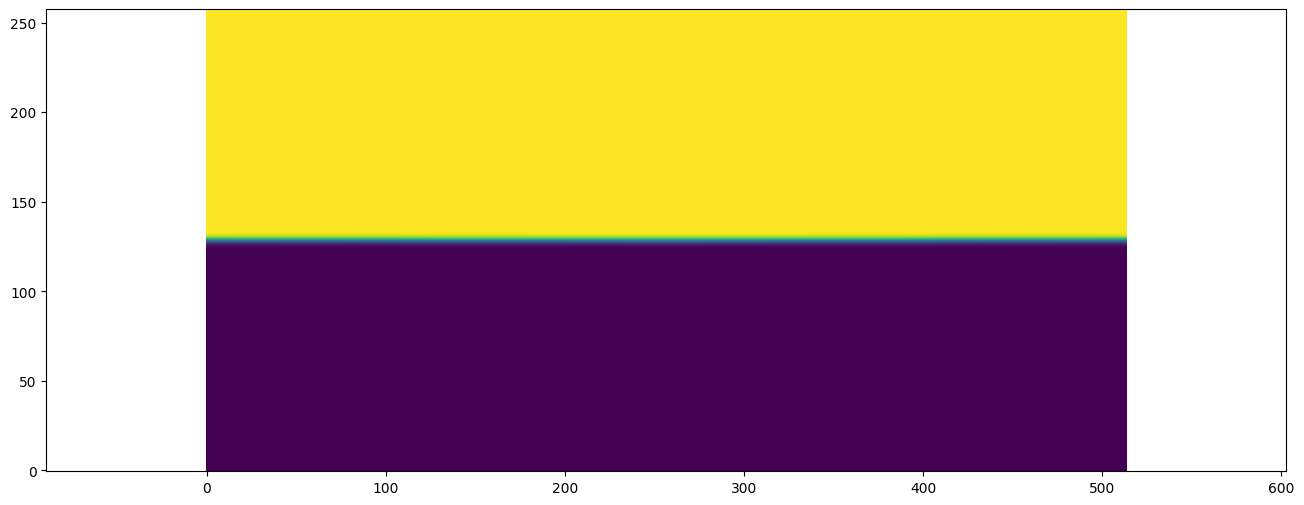

In [23]:
if 'is_test_run' not in globals():
    if gpu:
        dh.all_to_cpu()

    plt.scalar_field(dh.cpu_arrays["C"])

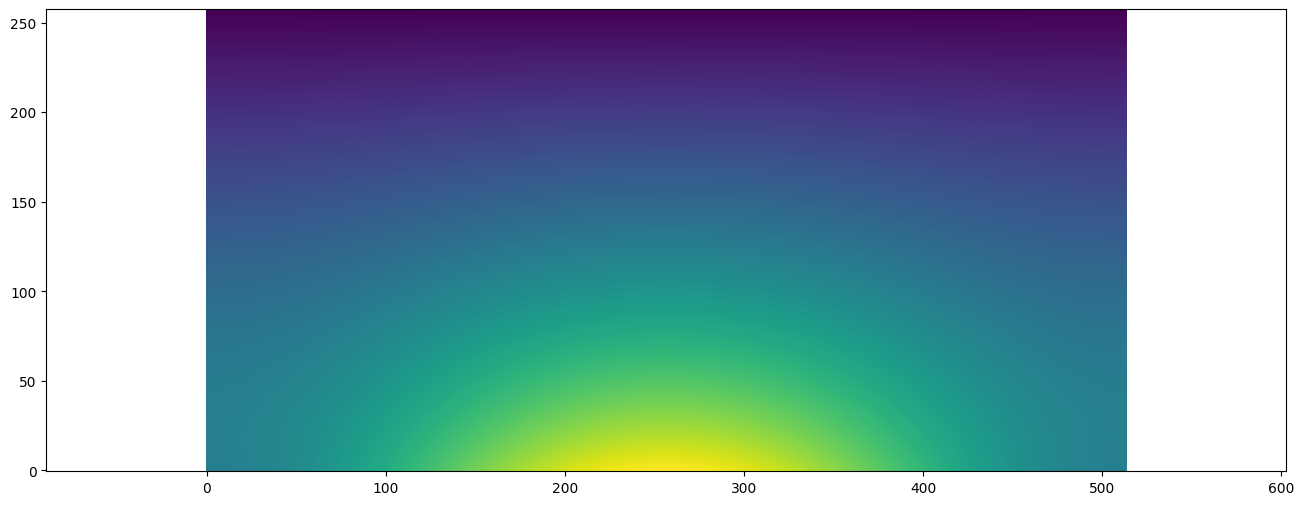

In [24]:
if 'is_test_run' not in globals():
    plt.scalar_field(dh.cpu_arrays["temperature"])

In [25]:
if 'is_test_run' not in globals():
    nx = domain_size[0]
    ny = domain_size[1]

    myDatX = np.arange(nx)-L0 
    myDatY = np.arange(ny)-L0//2
    XX, YY = np.meshgrid(myDatX, myDatY)

    u_calc = dh.gather_array(u.name, ghost_layers=False)

In [26]:
if 'is_test_run' not in globals():
    k_h = parameters.heat_conductivity_heavy
    k_l = parameters.heat_conductivity_light
    sigma_T = parameters.sigma_t
    mu_L = parameters.dynamic_viscosity_light
    x, y, u_x, u_y, t_a = analytical_solution_microchannel(L0, nx, ny, k_h, k_l, T_h, T_c, T_0, sigma_T, mu_L)

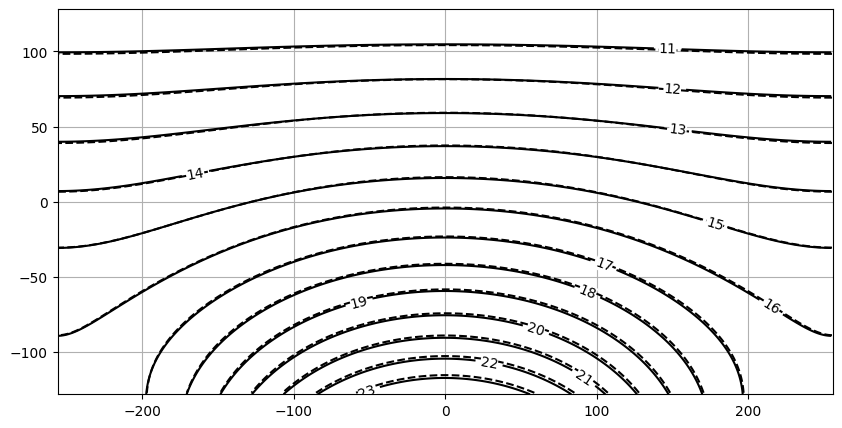

In [27]:
if 'is_test_run' not in globals():
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    levels = range(11,24)
    CS1 = ax.contour(x, y, t_a,linestyles='dashed', levels =levels, colors =['k'])
    plt.grid()
    CS2 = plt.contour(XX, YY, dh.gather_array(temperature.name, ghost_layers=False).T, levels =levels, colors =['k'])
    clabels = ax.clabel(CS2, inline=1, fontsize=10,fmt='%2.0lf')
    [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
    plt.ylim((-128,128))
    plt.xlim((-256,256))

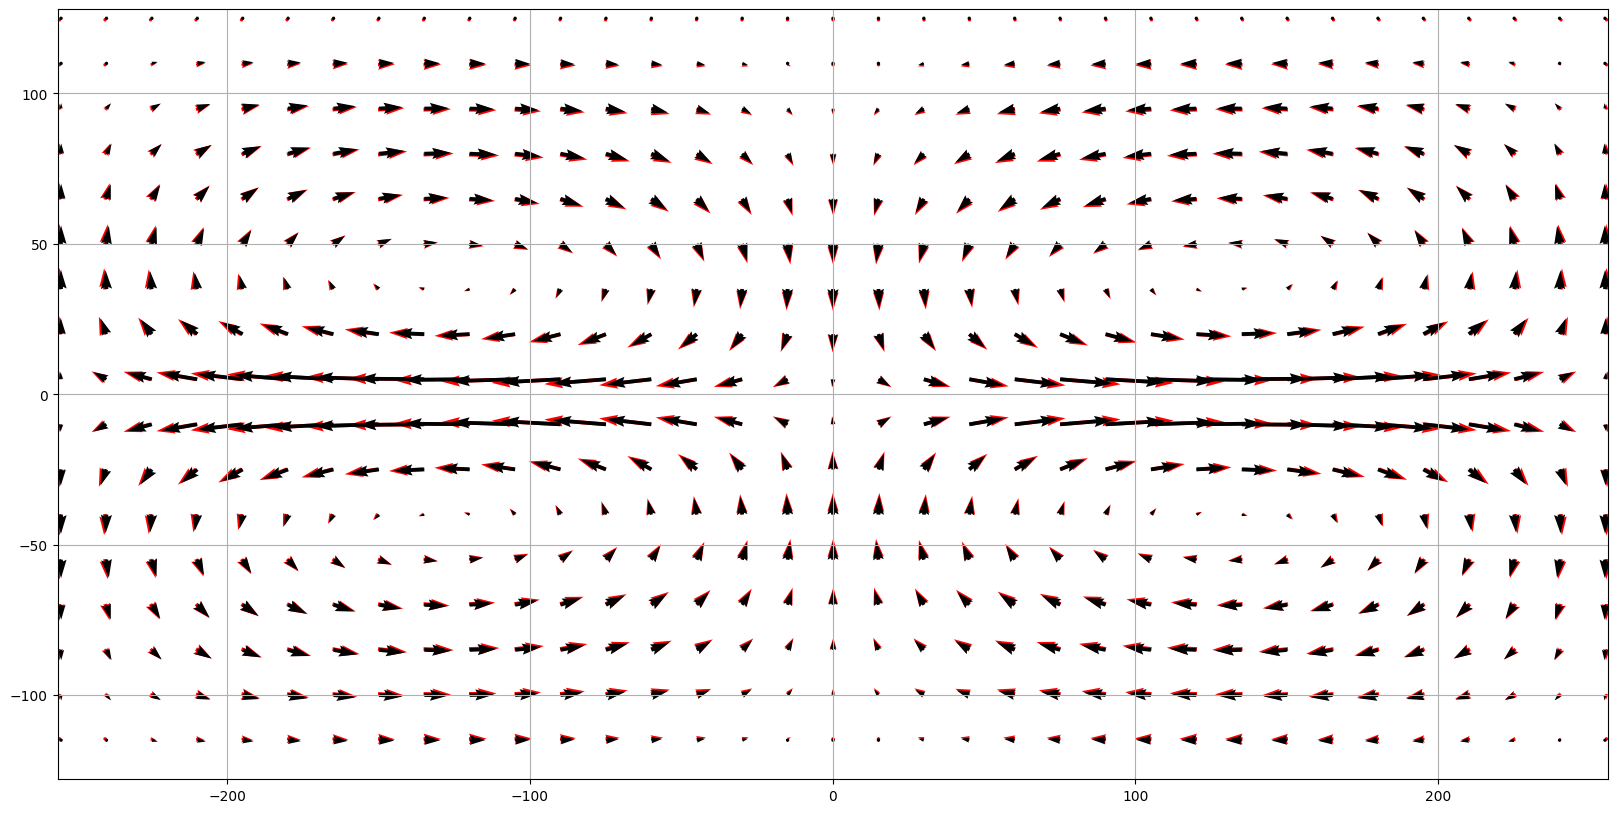

In [28]:
if 'is_test_run' not in globals():
    fig1, ax = plt.subplots()
    fig1.set_figheight(10)
    fig1.set_figwidth(20)
    excludeN = 15

    CS1 = ax.quiver(x[::excludeN,::excludeN]+1.1, y[::excludeN,::excludeN]-2.5, u_x.T[::excludeN,::excludeN].T, u_y.T[::excludeN,::excludeN].T,
                    angles='xy', scale_units='xy', scale=0.00001, color='r')
    CS1 = ax.quiver(XX[::excludeN,::excludeN]+1.1, YY[::excludeN,::excludeN]-2, u_calc[::excludeN,::excludeN, 0].T, u_calc[::excludeN,::excludeN, 1].T,
                    angles='xy', scale_units='xy', scale=0.00001)

    plt.grid()
    plt.ylim((-128,128))
    plt.xlim((-256,256))